# Metadata

```
Course:  DS 5001
Module:  03 Lab
Topic:   Demonstration of Simple Language Model
Author:  R.C. Alvarado
Date:    31 January 2023
```

**Purpose**: Demonstrates use of simple langauge model based on Berkeley restaurant data (from Jurafsky and Martin).

# Set Up

In [68]:
import pandas as pd
import numpy as np

# Make the Data

We convert these three tables into Pandas dataframes and use them to predict and generate sentences.

<img src="lm-data.png">

First, we create the table of unigrams, i.e. the priors or marginals of a bigram model.

We then convert these counts into probability estimates $p$ by competing the relative frequency of each event (word).

We also compute the information $i$ for each $p$.

Note that information $i$ is just the negative of the log probability of the event, so we can use this to compute the log probability of sentences later.

Finally, we convert $i$ into the optimally encoded message length $msg$ for the ngram to demonstrate Shannon's message encoding principle. 

We will compute $p$, $i$, and $msg$ for each of our tables.

In [69]:
data1 = dict(
    w0 = "i, want, to, eat, chinese, food, lunch, spend".split(", "),
    n = [2533, 927, 2417, 746, 158, 1093, 341, 278]
)

In [70]:
df1 = pd.DataFrame(data1).set_index(['w0'])
df1.n = df1.n.astype('int')

In [96]:
df1['p'] = df1.n / df1.n.sum()
df1['i'] = np.log2(1/df1.p)
df1['msg'] = df1.i.round(0).astype('int')

In [372]:
df1.sort_values('i')

,n,p,i,msg,code
w0,,,,,
i,2533,0.298246,1.745427,2,0
to,2417,0.284587,1.813057,2,10
food,1093,0.128694,2.957981,3,1000
want,927,0.109149,3.195633,3,1
eat,746,0.087837,3.509027,4,11
lunch,341,0.040151,4.638431,5,1001
spend,278,0.032733,4.933117,5,10000
chinese,158,0.018604,5.748278,6,100


Next, we create a table joint probabilities that will be the basis for our bigram model.

In [373]:
data2 = [row.split(", ") for row in """
i, i, 5
i, want, 837
i, eat, 9
i, spend, 2
want, i, 2
want, to, 608
want, eat, 1
want, chinese, 6
want, food, 6
want, lunch, 5
want, spend, 1
to, i, 2
to, to, 4
to, eat, 686
to, chinese, 2
to, lunch, 6
to, spend, 211
eat, to, 2
eat, chinese, 16
eat, food, 2
eat, lunch, 42
chinese, i, 1
chinese, food, 82
chinese, lunch, 1
food, i, 15
food, to, 15
food, chinese, 1
food, food, 4
lunch, i, 2
lunch, food, 1
spend, i, 1
spend, to, 1
""".split("\n")[1:-1]]

In [374]:
df2 = pd.DataFrame(data2, columns = ['w0', 'w1', 'n']).set_index(['w0','w1'])

In [375]:
df2.n = df2.n.astype('int')
df2['jp'] = df2.n / df2.n.sum()

In [376]:
df2.sort_values('n', ascending=False)

n        jp
w0      w1                    
i       want     837  0.324544
to      eat      686  0.265995
want    to       608  0.235750
to      spend    211  0.081815
chinese food      82  0.031795
eat     lunch     42  0.016285
        chinese   16  0.006204
food    to        15  0.005816
        i         15  0.005816
i       eat        9  0.003490
want    chinese    6  0.002326
        food       6  0.002326
to      lunch      6  0.002326
i       i          5  0.001939
want    lunch      5  0.001939
food    food       4  0.001551
to      to         4  0.001551
        chinese    2  0.000775
        i          2  0.000775
eat     to         2  0.000775
        food       2  0.000775
lunch   i          2  0.000775
want    i          2  0.000775
i       spend      2  0.000775
spend   i          1  0.000388
lunch   food       1  0.000388
chinese lunch      1  0.000388
food    chinese    1  0.000388
want    eat        1  0.000388
chinese i          1  0.000388
want    spend      1  0.000388
spend   to         1  0.000388

Next, we compute conditional probabilities $p$ with the formula $p(B|A) = \large \frac{P(A,B)}{P(A)}$ converted to $\large \frac{C(A,B)}{C(A)}$.

We also compute the information $i$ for each $p$.

Note that information $i$ is just the negative of the log probability of the event, so we can use this to compute the log probability of sentences later.

Finally, we convert $i$ into the optimally encoded message length $msg$ for the ngram to demonstrate Shannon's message encoding principle. 

In [377]:
df2['cp'] = df2.n / df1.n # These numbers match the textbook
# df2['cp'] = df2.jp / df1.p # Produces different numbers with identical trend
df2['i'] = np.log2(1/df2.cp)
df2['msg'] = np.round(df2.i).astype('int')

In [378]:
df2.sort_values('cp', ascending=False).style.background_gradient(cmap='YlGnBu')

We convert a selection from the narrow table into a wide one, projecting the second index feature `w1` onto the second axis.

This is strictly not necessary, but it is convenient for certain computations and it is visually appealing.

In [379]:
df3 = df2.cp.unstack(fill_value=0)

In [380]:
df3.style.background_gradient(cmap='YlGnBu', axis=None)

w1,chinese,eat,food,i,lunch,spend,to,want
w0,,,,,,,,
chinese,0.000000,0.000000,0.518987,0.006329,0.006329,0.000000,0.000000,0.000000
eat,0.021448,0.000000,0.002681,0.000000,0.056300,0.000000,0.002681,0.000000
food,0.000915,0.000000,0.003660,0.013724,0.000000,0.000000,0.013724,0.000000
i,0.000000,0.003553,0.000000,0.001974,0.000000,0.000790,0.000000,0.330438
lunch,0.000000,0.000000,0.002933,0.005865,0.000000,0.000000,0.000000,0.000000
spend,0.000000,0.000000,0.000000,0.003597,0.000000,0.000000,0.003597,0.000000
to,0.000827,0.283823,0.000000,0.000827,0.002482,0.087298,0.001655,0.000000
want,0.006472,0.001079,0.006472,0.002157,0.005394,0.001079,0.655879,0.000000


# Apply the Model

Now we generate sentences from the model and also compute their probabilities and perplexities.

We also demonstrate the relationship between sum of log probability, mean information, and perplexity.

In [398]:
N = 20
M = 10
results = []

# Generate N sentences
for i in range(N):
    
    # Get a start word from the unigram list (since we don't have sentence boundaries in our bigram model
    start = df1.sample(weights='n')
    w0 = start.index[0]
    i = start.i.values[0]
    
    # Initialize sentence features
    W = [w0]
    I = [i]
    LP = [-i]
    
    # Select M words for each sentence
    for j in range(M-1):
        w1 = df3.loc[w0].sample(weights=df3.loc[w0].values).index[0]
        i = df2.loc[(w0, w1), 'i']
        W.append(w1)
        I.append(i)
        LP.append(-i)
        w0 = w1

    # Compute sentence stats
    S = pd.DataFrame(dict(w=W, i=I, lp=LP))
    i_mean = S.i.mean()
    lp_sum = S.lp.sum()
    pp = 2**(i_mean)
    sent_str = ' '.join(W)
    
    # Append to results 
    results.append((sent_str, lp_sum, i_mean, pp))
    
# Put results in a dataframe
R = pd.DataFrame(results, columns=['sentence', 'logprob', 'i_mean', 'pp'])

# Keep only unique sentences, i.e. treat sentences as index values
sentence_counts = R.sentence.value_counts().to_frame('n')
R = R.drop_duplicates()
R = R.reset_index(drop=True).set_index('sentence')
R['n'] = sentence_counts

# Display results
R.sort_values('i_mean', ascending=True).style.background_gradient(cmap="YlGnBu")

,logprob,i_mean,pp,n
sentence,,,,
i want to eat lunch i want to eat lunch,-25.506449,2.550645,5.858961,2
i want to eat chinese food food i want to,-28.744981,2.874498,7.333480,1
i want to spend to eat lunch i want to,-31.175641,3.117564,8.679212,2
spend i want to eat chinese food i want to,-31.957534,3.195753,9.162577,1
to eat chinese food i want to eat lunch food,-32.893766,3.289377,9.776897,1
eat to eat chinese food i want to eat lunch,-34.719140,3.471914,11.095586,1
to eat lunch i want to spend to eat lunch,-35.004877,3.500488,11.317533,1
want to spend i want to eat food i want,-35.791724,3.579172,11.951936,1
to eat lunch food i want to eat lunch i,-37.968848,3.796885,13.898765,1


# Interpet Results

Compare mean `i` to the sum of log `p`. Notice they are identical when normalized by mean.

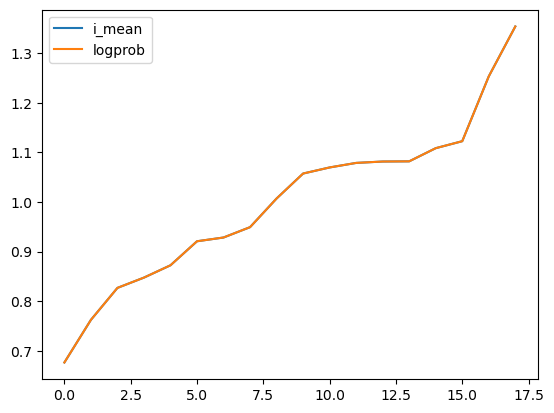

In [399]:
(R / R.mean()).sort_values('i_mean')[['i_mean','logprob']].reset_index().plot();

Compre perplexity `pp` to mean information `i`. Notice how perplexity amplifies the difference.

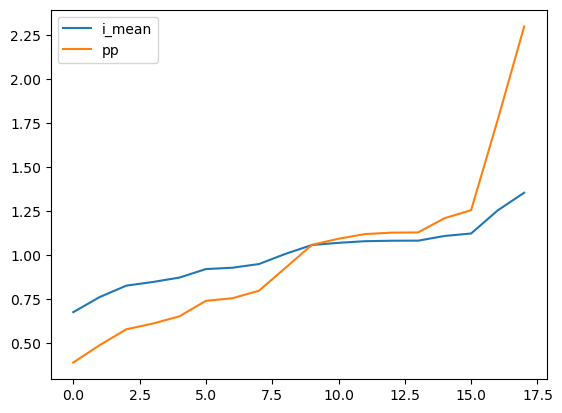

In [400]:
(R / R.mean()).sort_values('i_mean')[['i_mean','pp']].reset_index().plot();

So, we will use perplexity to measure of how well a model performs.

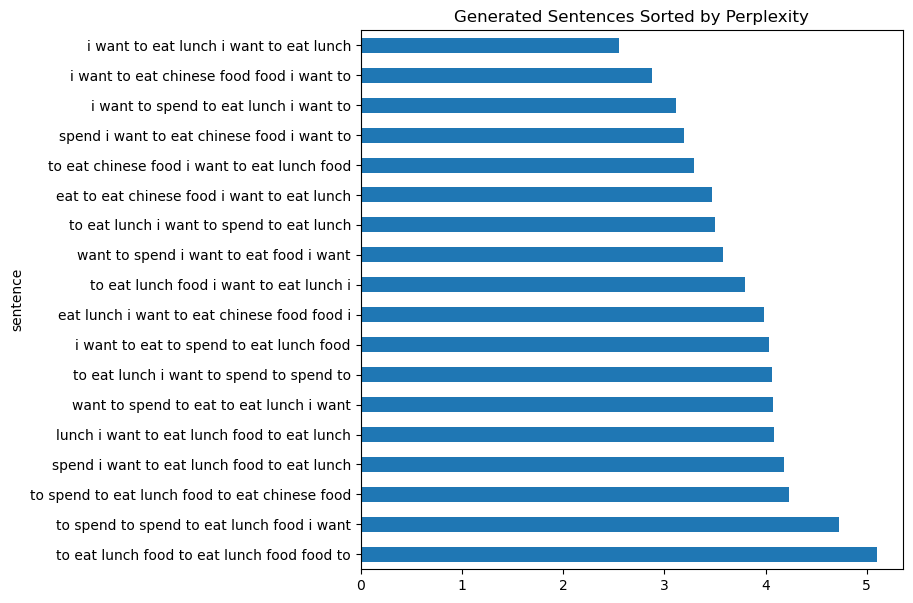

In [401]:
R.reset_index().set_index('sentence').sort_values('pp').i_mean.sort_values(ascending=False)\
    .plot.barh(figsize=(7,7), title="Generated Sentences Sorted by Perplexity");